# **Modelos de clasificación empleando funciones de densidad Gausianas**

In [14]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/mariabda2/ML_2022/main/init.py
import init; init.init(force_download=False);

In [15]:
# Bibliotecas

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.colors import ListedColormap
import seaborn as sbs

import numpy as np

import math
from sklearn import datasets

#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always")


El objetivo es encontrar las funciones de densidad de probabilidad $$p({\bf{x}})$$ de las clases que permiten realizar la clasificación de una muestra con base en la probabilidad de que esa muestra pertenezca a una u otra clase.

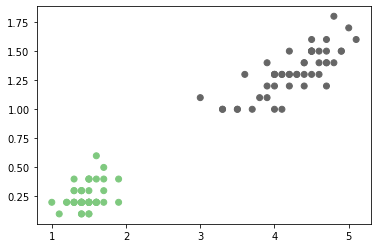

In [16]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X2 = X[:100][:,2:4]
Y2 = y[:100]
plt.scatter(X2[:,0], X2[:,1], c=Y2,cmap='Accent');

Si asumimos por ejemplo que la fdp de cada clase en la figura anterior la vamos a modelar usando funciones de probabilidad Gausianas, entonces la fdp de cada una estará dada por la función: 

$$p({\bf{x}})=\frac{1}{(2\pi)^{d/2}\left| \Sigma \right|^{1/2} } \exp\left[ -\frac{1}{2} ({\bf{x}} - {\bf{\mu}})^T \Sigma^{-1} ({\bf{x}} - {\bf{\mu}}) \right]$$

Es necesario tener en cuenta que los problemas que estamos abordando son de múltiples variables de entrada, entonces la función Gausiana anterior corresponde a una función de varias variables, en donde $\mu$ corresponde a un vector de medias, es decir un vector que contiene las medias de cada variable y $\Sigma$ es la matriz de covarianza.

$${\bf{\mu}} = \{\mu_1,\mu_2,\cdots,\mu_d\}, \;\; \Sigma = \begin{bmatrix}
    \sigma_1^2 & \rho_{1,2} \sigma_1 \sigma_2 & \rho_{1,3} \sigma_1 \sigma_3 & \dots  & \rho_{1,d} \sigma_1 \sigma_d \\
    \rho_{2,1} \sigma_2 \sigma_1 & \sigma_2^2 & \rho_{2,3} \sigma_2 \sigma_3 & \dots  & \rho_{2,d} \sigma_2 \sigma_d \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \rho_{d,1} \sigma_d \sigma_1 & \rho_{d,2} \sigma_d \sigma_2 & \rho_{d,3} \sigma_d \sigma_3 & \dots  & \sigma_d^2
\end{bmatrix} $$

Una vez hemos decido que el modelo que reprsentará cada clase será un fdp Gausiana, podemos utilizar el criterio de Máxima Verosimilitud visto antes para estimar los parámetros de la función. Si tenemos $N$ muestras i.i.d. ${\bf{x}}_i \sim {\mathcal{N}}({\bf{\mu}},\Sigma)$, entonces los parámetros de la función de densidad se pueden estimar a partir del criterio ML como:

$$\hat{\mu} = \frac{1}{N}\sum_{i=1}^{N} {\bf{x}}_i$$

$$\hat{\Sigma} = \frac{1}{N}\sum_{i=1}^{N} ({\bf{x}}_i - \hat{\mu})({\bf{x}}_i - \hat{\mu})^T$$

Si el modelo de clasificación que pretendemos implementar corresponde entonces a un modelo basado en funciones discriminantes Gausianas, el procedimiento que debemos seguir es el siguiente:

## **Entrenamiento**

<li>Tomar el conjunto de muestras de entrenamiento y separarlas en $C$ subconjuntos, donde $C$ es el número de clases a reconocer, es decir que cada subconjunto contiene únicamente muestras de una clase. </li>
<li>Utilizar cada uno de los subconjuntos y estimar los valores del vector de medias y la matriz de covarianza.</li>
<li>Con los valores de media y covarianza definir una función $p$ (Ecuación 1.), para cada una de las clases.</li>


## **Procedimiento para clasificar una nueva muestra**

Cuando al sistema ingrese una nueva muestra, es decir un vector ${\bf{x}}$* , para el que no conocemos su clase y deseamos predecirla, deberemos entonces:
<li>Evaluar ${\bf{x}}^*$ en cada una de las funciones $p_j$, para cada una las clases, $j=1,...,C$. Con esto vamos a establecer la probabilidad de que la muestra nueva pertenezca a cada una de las clases, de acuerdo con el modelo que hemos asumido (Gausiano)</li>
<li>La clase asignada a la muestra ${\bf{x}}^*$, será la clase para la cual la probabilidad sea mayor.</li>

$$C* = \mathop {\arg \max }\limits_k p_k({\bf{x}}^*)$$

Si aplicamos este método al conjunto de muestras de la primera figura obtendremos la siguiente frontera de clasificación:

In [17]:
def DistribucionGaussiana(X,Mu,Sigma):
    
    d = X.shape[1]
    SigmaInversa = np.linalg.inv(np.array(Sigma))
    PrimerTermino = (1/(((2*math.pi)**(d/2))*math.sqrt(np.linalg.det(Sigma))))
    
    primerDot = np.dot((X-Mu),SigmaInversa)
    segundoDot = np.dot(primerDot,(X-Mu).T)
    Exponencial = math.exp(-0.5*segundoDot)
    
    Probabilidad = PrimerTermino * Exponencial
    
    return Probabilidad

In [18]:
def FuncionDiscriminanteGaussiana(Tipo=1):
    x_min, x_max = X[:, 2].min() - .1, X[:, 2].max() + .1
    y_min, y_max = X[:, 3].min() - .1, X[:, 3].max() + .1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    #Estimación de medias y Covarianzas
    Mu1 = np.mean(X2[:50,:], axis=0)
    Mu2 = np.mean(X2[51:,:], axis=0)
    
    Sigma1 = np.cov((X2[:50,:]).T)
    Sigma2 = np.cov((X2[51:,:]).T)
    
    Sigma3 = (0.5*(Sigma1+Sigma2))
    
    Z = np.zeros((100,100))
    
    #Evaluando las fdp's en una malla de valores
    for i in range(100):
        for j in range(100):
            Xtem = np.array([xx[1,i],yy[j,1]])[np.newaxis]
            
            if Tipo == 0 :
            
                p1 = DistribucionGaussiana(Xtem,Mu1,Sigma1)
                p2 = DistribucionGaussiana(Xtem,Mu2,Sigma2)
            elif Tipo == 1:
                p1 = DistribucionGaussiana(Xtem,Mu1,Sigma3)
                p2 = DistribucionGaussiana(Xtem,Mu2,Sigma3)
            if p1 >= p2:
                Z[i,j] = 1
            else:
                Z[i,j] = 0
    plt.figure()
    plt.pcolormesh(xx, yy, Z.T, cmap='Accent')
    plt.scatter(X2[:,0], X2[:,1], c=Y2)
    plt.show()    

In [19]:
from ipywidgets import interact,interactive,fixed, interact_manual
import ipywidgets as widgets

interact(FuncionDiscriminanteGaussiana,Tipo=[('Igual Matriz de Covarianza', 1), ('Diferente Matriz de Covarianza', 0)])

interactive(children=(Dropdown(description='Tipo', options=(('Igual Matriz de Covarianza', 1), ('Diferente Mat…

<function __main__.FuncionDiscriminanteGaussiana>

----------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
from matplotlib.patches import Ellipse
def plot_ellipse(ax, mu ,sigma):

    vals, vecs = np.linalg.eigh(sigma)
    
    x , y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y,x))
    
    w,h = 4* np.sqrt(vals)
    
    ax.tick_params(axis='both',which='major',labelsize=10)
    ellipse = Ellipse(mu,w,h,theta,color='k')
    ellipse.set_alpha(0.2)
    ax.add_artist(ellipse)

**El modelo anterior tiene tres posibles casos:**

## **Caso 1: Matriz de covarianza esférica** 
Si las matrices de covarianza se consideran de la forma: </b> 

$$\Sigma = \sigma^2 {\bf{I}}$$

</b> donde ${\bf{I}}$ es la matriz identidad.

En este caso lo que se asume es todas las características se consideran estadísticamente independientes y de igual varianza. Cada clase se considera como un grupo agrupado dentro de un círculo (hiperesfera) perfecto al rededor de su media.

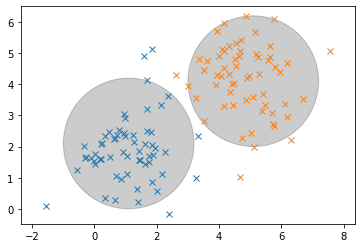

In [21]:
Cov = np.identity(2) * 1.1
Mean = [1.1,2.1]
Mean2 = [5.1,4.1]
ax = plt.subplot(111)
x, y  = np.random.multivariate_normal(Mean, Cov, 60).T
x2, y2  = np.random.multivariate_normal(Mean2, Cov, 60).T
ax.plot(x,y,'x')
ax.plot(x2,y2,'x')
ax.axis('equal')

plot_ellipse(ax,Mean,Cov)
plot_ellipse(ax,Mean2,Cov)

## **Caso 2: Matriz de covarianza diagonal** 
Si las matrices de covarianza se consideran diagonales. En este caso lo que se asume es todas las características se consideran estadísticamente independientes pero no de igual varinza. En este caso las clases se consideran agrupadas en parábolas cuyo eje principal puede estar a lo largo de cualquiera de las características. Este modelo es equivalente al clasificador conocido como <b>Naïve Bayes Classifier</b> o clasificador Bayesiano ingenuo (<mark>Consultar</mark>).

## **Caso 3: Matriz de covarianza completa** 
Es el caso más general, en el que las matrices de covarianza de los modelos se consideran completas y las clases se consideran agrupadas en parábolas cuyo eje principal puede estar en cualquier dirección, es por consiguiente el más flexible.

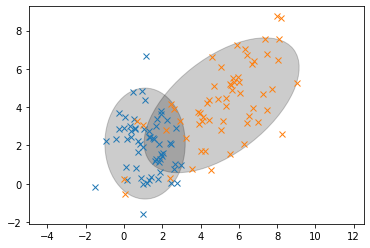

In [22]:
Cov = [[1.1,0],[0,2.1]]
Cov2 = [[4.1,2],[2,3.1]]
Mean = [1.1,2.1]
Mean2 = [5.1,4.1]
ax = plt.subplot(111)
x, y  = np.random.multivariate_normal(Mean, Cov, 60).T
x2, y2  = np.random.multivariate_normal(Mean2, Cov2, 60).T
ax.plot(x,y,'x')
ax.plot(x2,y2,'x')
ax.axis('equal')

plot_ellipse(ax,Mean,Cov)
plot_ellipse(ax,Mean2,Cov2)

Los tres casos anteriores corresponden a:

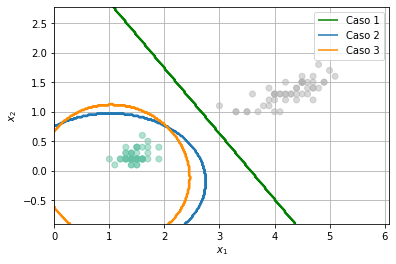

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

clf1 = LinearDiscriminantAnalysis()
clf1.fit(X2,Y2.flatten())
clf2 = GaussianNB()
clf2.fit(X2,Y2.flatten())
clf3 = QuadraticDiscriminantAnalysis()
clf3.fit(X2,Y2.flatten())
plt.scatter(X2[:,0],X2[:,1],c=Y2.flatten(), cmap='Set2',alpha=0.5)

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z1 = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z3 = clf3.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)
Z3 = Z3.reshape(xx.shape)
cs1 = plt.contour(xx, yy, Z1, colors='green')
cs2 = plt.contour(xx, yy, Z2, colors='C0')
cs3 = plt.contour(xx, yy, Z3, colors='darkorange')
h1,_ = cs1.legend_elements()
h2,_ = cs2.legend_elements()
h3,_ = cs3.legend_elements()
labels = ['Caso 1','Caso 2', 'Caso 3']
plt.legend([h1[0], h2[0], h3[0]], ['Caso 1','Caso 2', 'Caso 3'])
for i in range(len(labels)):
    cs1.collections[i].set_label(labels[i])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid()

----------------------------------------------------------------------------------------------------------------------------------------------

#### NOTA:

*   Modelo de clasificación <b>Generativo</b>, porque en la clasificación se realiza modelando cada clase de manera independiente, utilizando un modelo basado en funciones de densidad de probabilidad, que una vez ajustadas, se pueden usar como generadoras de muestras de cada una de las clases.  

*   El modelo de clasificación basado en regresión logística, corresponde a un modelo de clasificación <b>Discriminativo</b> porque en ese caso, el modelo se entrenó con muestras de las dos clases al mismo tiempo y el objetivo no era describir una clase u otra, sino, diferenciarlas.